# Загрузка и просмотр иображений

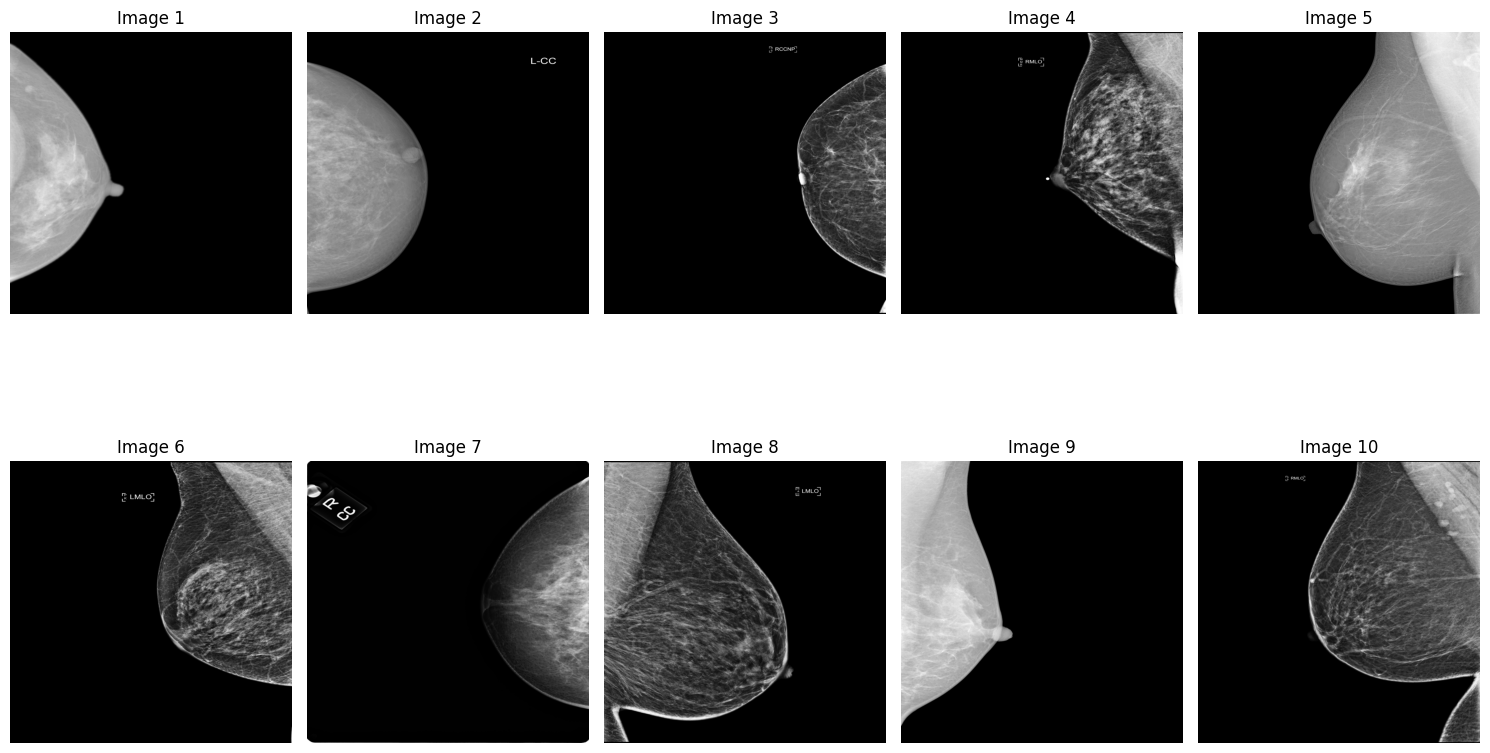

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Путь к директории с изображениями
images_dir = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/'

# Собираем пути ко всем изображениям
image_paths = []
for dirname, _, filenames in os.walk(images_dir):
    for filename in filenames:
        if filename.endswith('.png'):  # Проверяем, что это PNG
            image_paths.append(os.path.join(dirname, filename))

# Проверяем, есть ли изображения
if len(image_paths) == 0:
    print("Изображения не найдены!")
else:
    # Выбираем 10 случайных изображений
    random_images = random.sample(image_paths, min(10, len(image_paths)))

    # Отображаем изображения
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # 2 строки, 5 колонок
        plt.imshow(img, cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


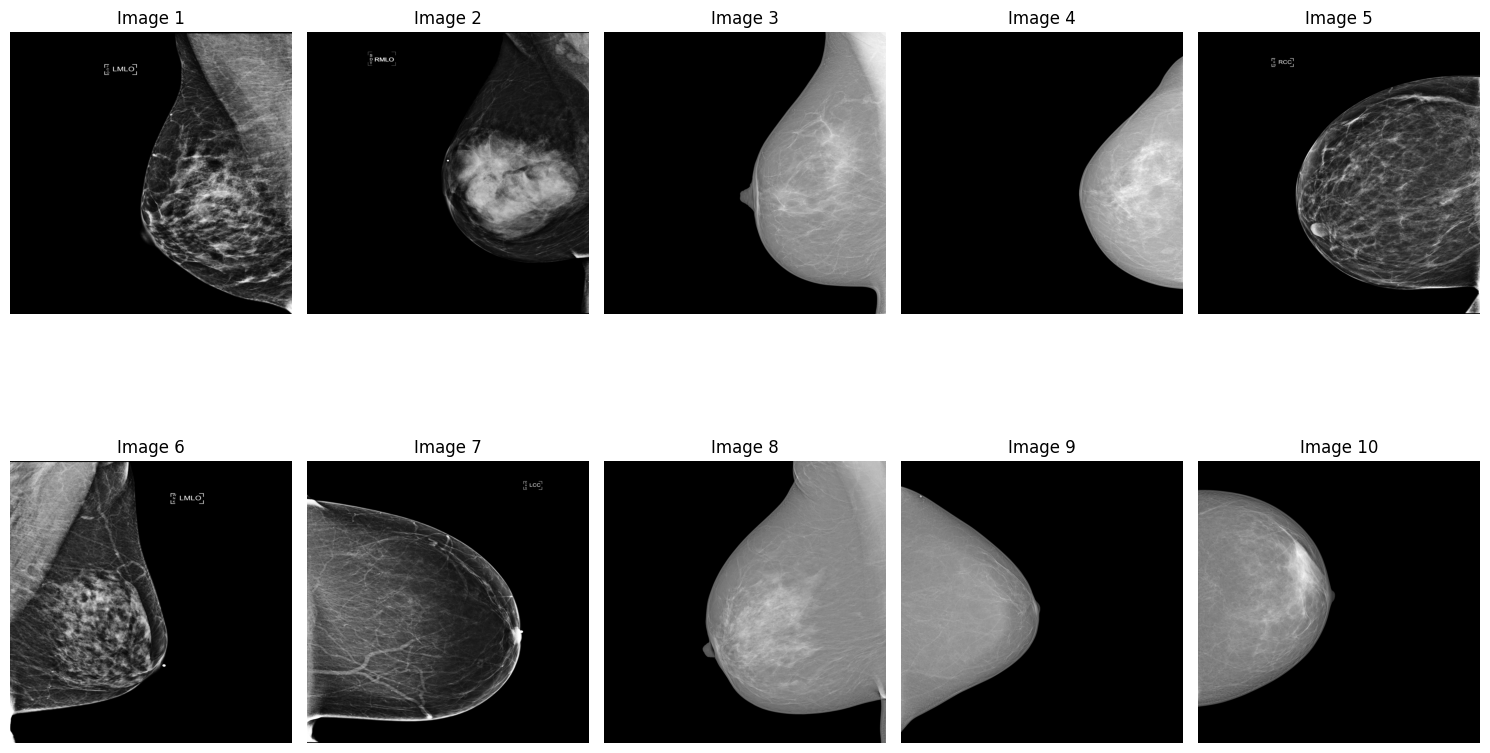

In [3]:
    # Выбираем 10 случайных изображений
    random_images = random.sample(image_paths, min(10, len(image_paths)))

    # Отображаем изображения
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # 2 строки, 5 колонок
        plt.imshow(img, cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
print("Количество изображений :",len(image_paths))

# Вывод размеров изображений
image_sizes = []
img = Image.open(image_paths[0])
image_sizes.append(img.size)
print(f"Размер изображений : {img.size}")

Количество изображений : 54706
Размер изображений : (1024, 1024)


# Предобработка данных

## 1 - Аномалии за пределами области интереса
Мы должны начать с поиска аномалий, которые существуют за пределами очерченной области интереса. Визуально говоря, нас интересует только часть изображений, относящаяся к ткани молочной железы. Любые другие артефакты изображения за пределами ткани молочной железы могут сбить с толку любую из наших моделей машинного обучения. Мы должны проверить, есть ли какие-либо подобные аномалии, и определить метод их фильтрации.

Один из способов справиться с этими внешними проблемами - найти контуры, которые отделяют фактическое изображение груди от фоновой информации, а затем замаскировать области за пределами ткани молочной железы.

In [5]:
import cv2
import numpy as np

def true_norm(img):
    norm = (img - np.min(img))
    norm = (norm / np.max(norm)) * 255
    return norm.astype(np.uint8)

def mask_external_contour(pixels):
    contours, _ = cv2.findContours(pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(pixels.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    return cv2.bitwise_and(pixels, mask)

def get_clean_image(img):
    return mask_external_contour(true_norm(img))

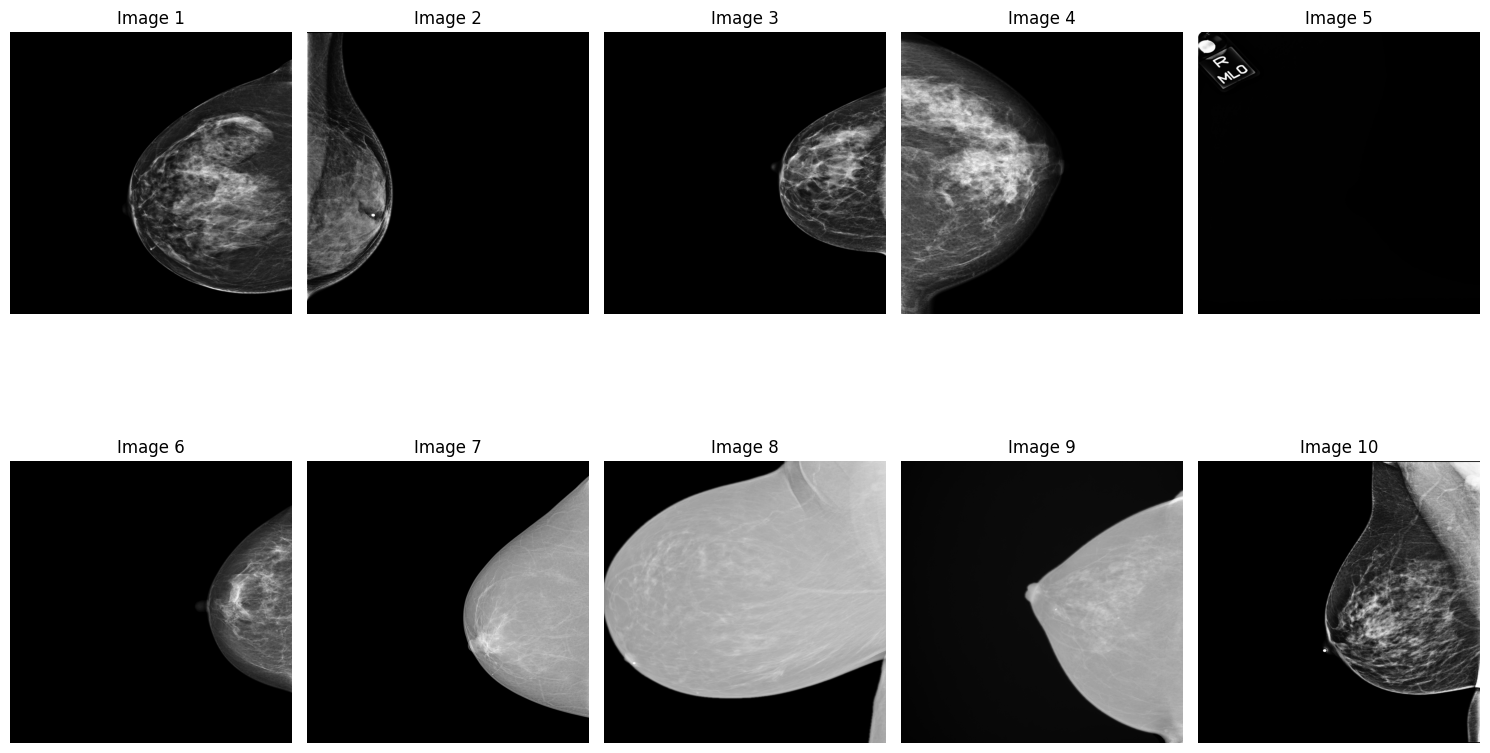

In [6]:
    # Выбираем 10 случайных изображений
    random_images = random.sample(image_paths, min(10, len(image_paths)))
    # Отображаем изображения
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # 2 строки, 5 колонок
        plt.imshow(get_clean_image(img), cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

С некоторыми изображениями может потребоваться определенная осторожность, поскольку может присутствовать несколько контуров, а в примере кода сохраняется только самый большой. В некоторых экстремальных обстоятельствах это может оказаться нецелесообразным. Например как на изображении 6

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/64411/32630261.png'

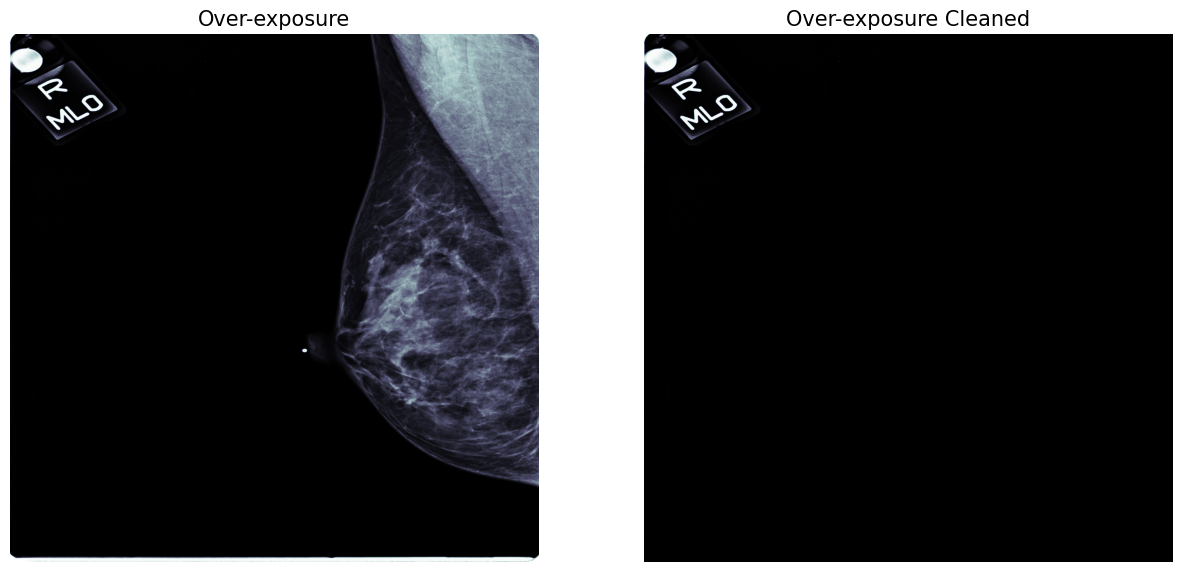

In [7]:
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 16))

sns.set_style('darkgrid')
sns.set_palette('Set2')

axs = axs.flatten()

_ = axs[0].imshow(Image.open(random_images[4]), cmap="bone")
_ = axs[0].axis("off")
_ = axs[0].set_title("Over-exposure", fontsize=15)
_ = axs[1].imshow(get_clean_image(Image.open(random_images[4])), cmap="bone")
_ = axs[1].axis("off")
_ = axs[1].set_title("Over-exposure Cleaned", fontsize=15)

В этом случае выбранная область контура была самой большой доступной областью, но из-за фонового шума этот контур занимает ту часть изображения, на которую мы не хотим смотреть. Один из способов обойти эту проблему - изучить размер области, выделенной контуром. На большинстве слайдов фактическая площадь ткани намного меньше общей площади всего изображения. Итак, в качестве двойной проверки того, что была выбрана правильная часть изображения, мы можем просто нарисовать ограничивающую рамку вокруг сгенерированного контура и измерить, насколько большую площадь он занимает. Затем мы можем выделить часть изображения, которая не содержалась в контуре, и нарисовать вокруг нее новый контур. Затем мы берем область контура, которая меньше из двух, при условии, что область контура занимает где-то около 20%-40% от общей площади слайда. Ниже приведен простой алгоритм, который делает это, с результирующими изображениями, которые он отображает.

In [8]:
RESCALE_HEIGHT = 1024
RESCALE_HEIGHT = 1024


def mask_external_contour_new(img):
    # Find the biggest contour and calculate size of bounding box that encapsulates it
    img_copy1 = img.copy()
    contours, _ = cv2.findContours(img_copy1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img_copy1.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    cv2.bitwise_and(img_copy1, mask, img_copy1)
    _, _, rect1_width, rect1_height = cv2.boundingRect(contour)
    
    # Select the area not covered by the contour by masked off the contoured area
    img_copy2 = img.copy()
    mask = np.empty(img_copy2.shape, dtype=np.uint8)
    mask.fill(255)
    cv2.drawContours(mask, [contour], -1, 0, cv2.FILLED)
    cv2.bitwise_and(img_copy2, mask, img_copy2)
    
    # Now find the largest contour in the side that wasn't masked off
    contours, _ = cv2.findContours(img_copy2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # If we can't find one, then just return the previously found image
    try:
        contour = max(contours, key=cv2.contourArea)
    except Exception:
        return img_copy1
    
    # Generate a new mask for the other side of the image
    mask = np.zeros(img_copy2.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
    cv2.bitwise_and(img_copy2, mask, img_copy2)
    
    # Compare rectangle sizes
    _, _, rect2_width, rect2_height = cv2.boundingRect(contour)
    rect1_area = rect1_width * rect1_height
    rect2_area = rect2_width * rect2_height
    rect1_area_pct = rect1_area / (RESCALE_WIDTH * RESCALE_HEIGHT)
    rect2_area_pct = rect2_area / (RESCALE_WIDTH * RESCALE_HEIGHT)
    
    # Return the smallest bounded image
    if rect1_area < rect2_area:
        return img_copy1
    
    # But make sure the smallest bounded image is still a significant size
    if rect2_area_pct > 0.20:
        return img_copy2
    
    return img_copy1

def get_clean_image_new(image):
    return mask_external_contour_new(true_norm(image))

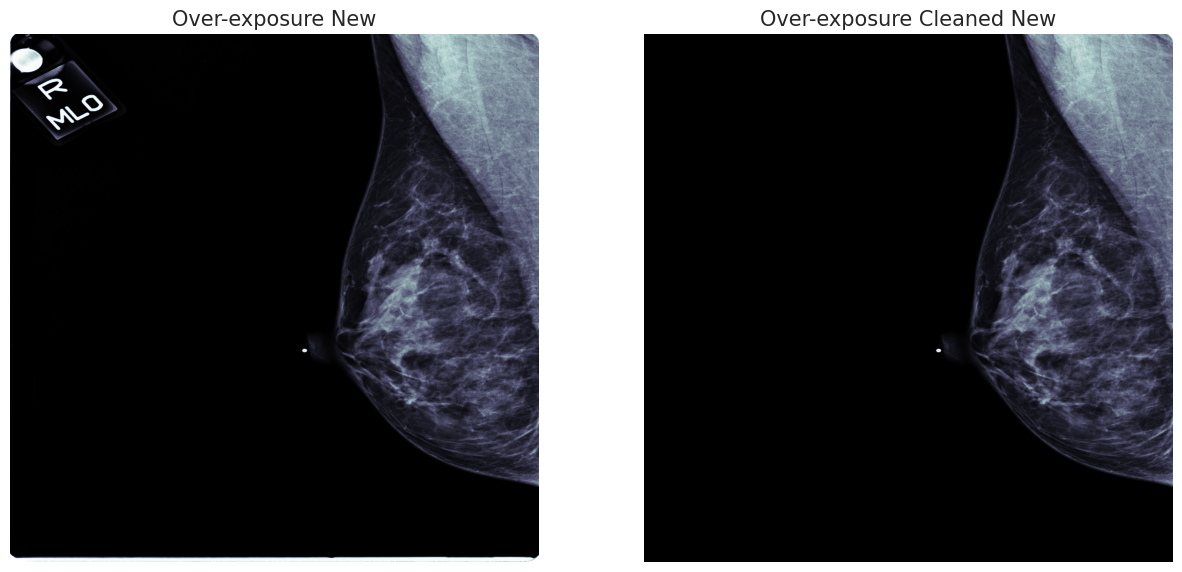

In [9]:
import seaborn as sns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 16))

sns.set_style('darkgrid')
sns.set_palette('Set2')

RESCALE_WIDTH = 1024
RESCALE_HEIGHT = 1024

axs = axs.flatten()

_ = axs[0].imshow(Image.open(random_images[4]), cmap="bone")
_ = axs[0].axis("off")
_ = axs[0].set_title("Over-exposure New", fontsize=15)
_ = axs[1].imshow(get_clean_image_new(Image.open(random_images[4])), cmap="bone")
_ = axs[1].axis("off")
_ = axs[1].set_title("Over-exposure Cleaned New", fontsize=15)

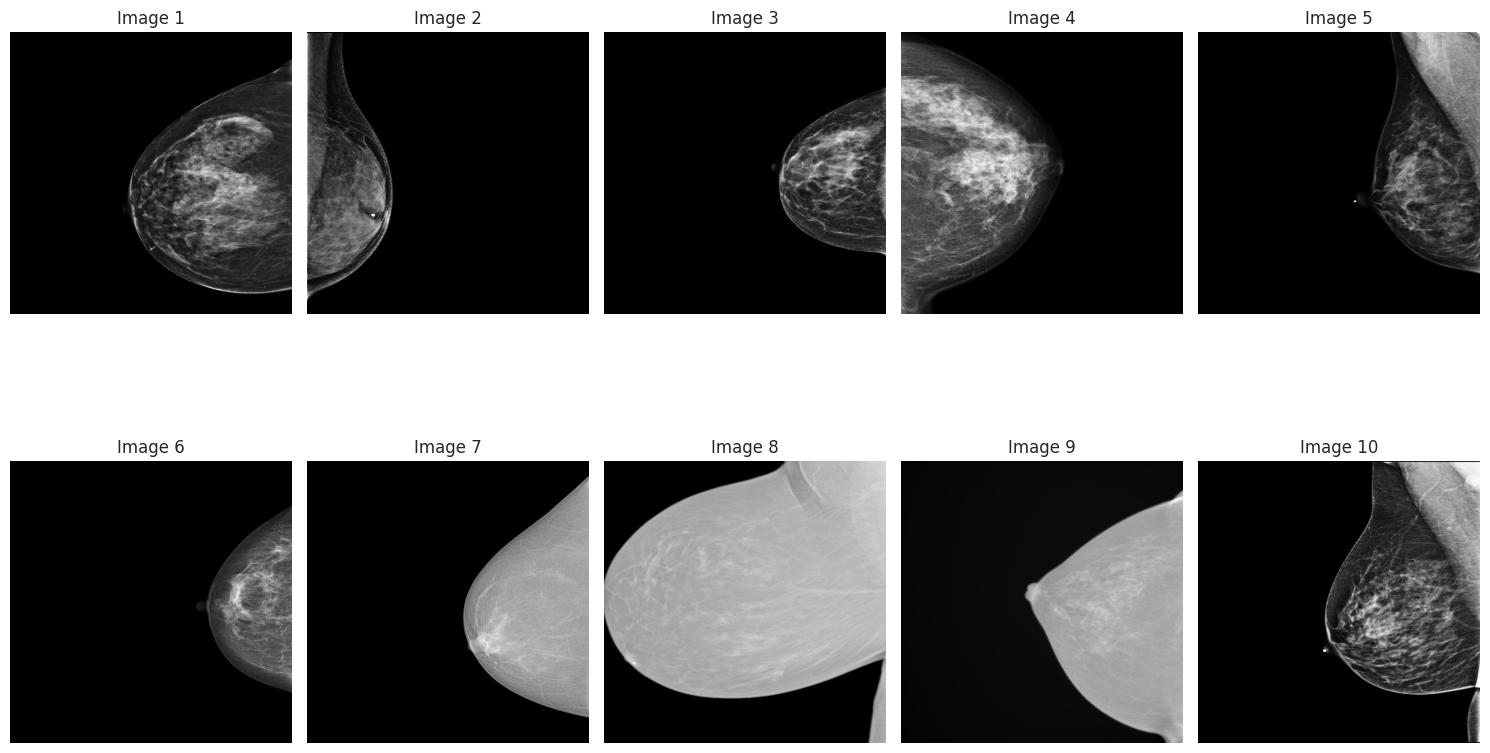

In [10]:
    # Отображаем изображения
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # 2 строки, 5 колонок
        plt.imshow(get_clean_image_new(img), cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

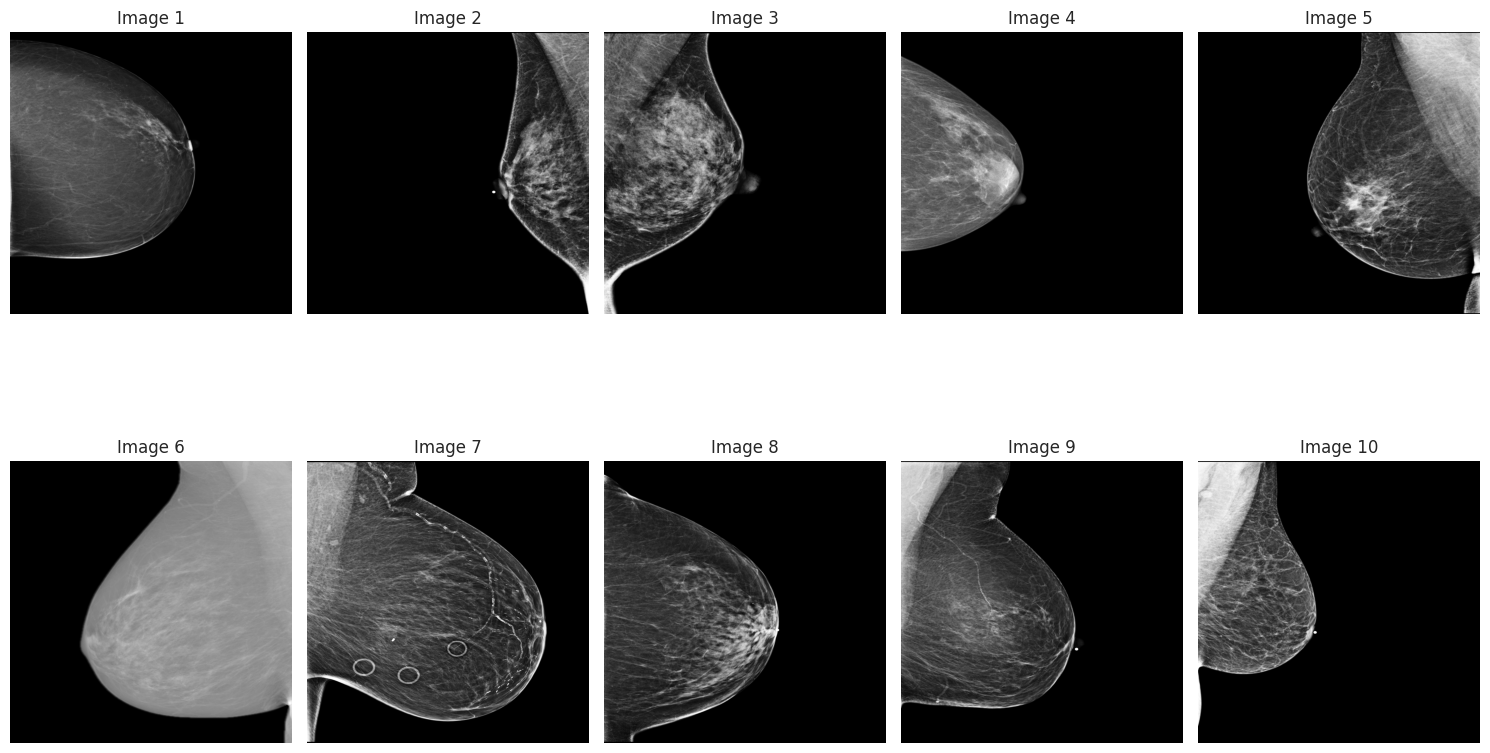

In [16]:
    # Выбираем 10 случайных изображений
    random_images_new = random.sample(image_paths, min(10, len(image_paths)))
    # Отображаем изображения
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(random_images_new):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # 2 строки, 5 колонок
        plt.imshow(get_clean_image_new(img), cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Это все еще не идеально, Однако преимущество этого подхода в том, что для определения интересующей области не требуется отдельная обученная модель. Здесь можно было бы провести будущую работу по корректировке порогового значения того, что следует считать частью интересующего контура, однако, вероятно, что универсального решения для всех при таком подходе не будет.

### 2 - Внутренние аномалии - круглые маркеры
На нескольких изображениях, похоже, уже есть внутренняя разметка. Первая аномалия отображается в виде мест, обведенных кружком. Вот несколько примеров:

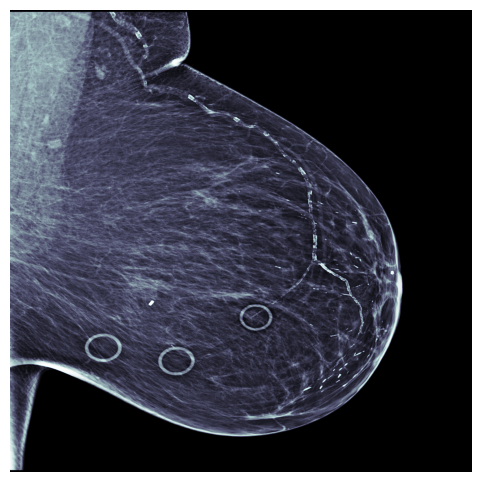

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.set_style('darkgrid')
sns.set_palette('Set2')

#axs = axs.flatten()

_ = axs.imshow(get_clean_image_new(Image.open(random_images_new[6])), cmap="bone")
_ = axs.axis("off")

Основные замечания о круглых маркерах:
- Маркеры могут быть сделаны из-за того, что специалист отметил определенные области для дальнейшего изучения.
- Маркеры могут быть связаны, а могут и не быть, со случаями рака, что может сбить с толку алгоритм машинного обучения, поскольку они сами по себе крайне аномальны по своей природе по сравнению с тканями молочной железы и их довольно легко обнаружить.
- Маркеры могут отображаться на одном или нескольких изображениях пациента. В зависимости от угла наклона и плотности ткани маркеры могут отсутствовать вообще.

### 3 - Снимки с имплантами
Мы также должны проверить, влияет ли наличие имплантатов на доступные снимки.

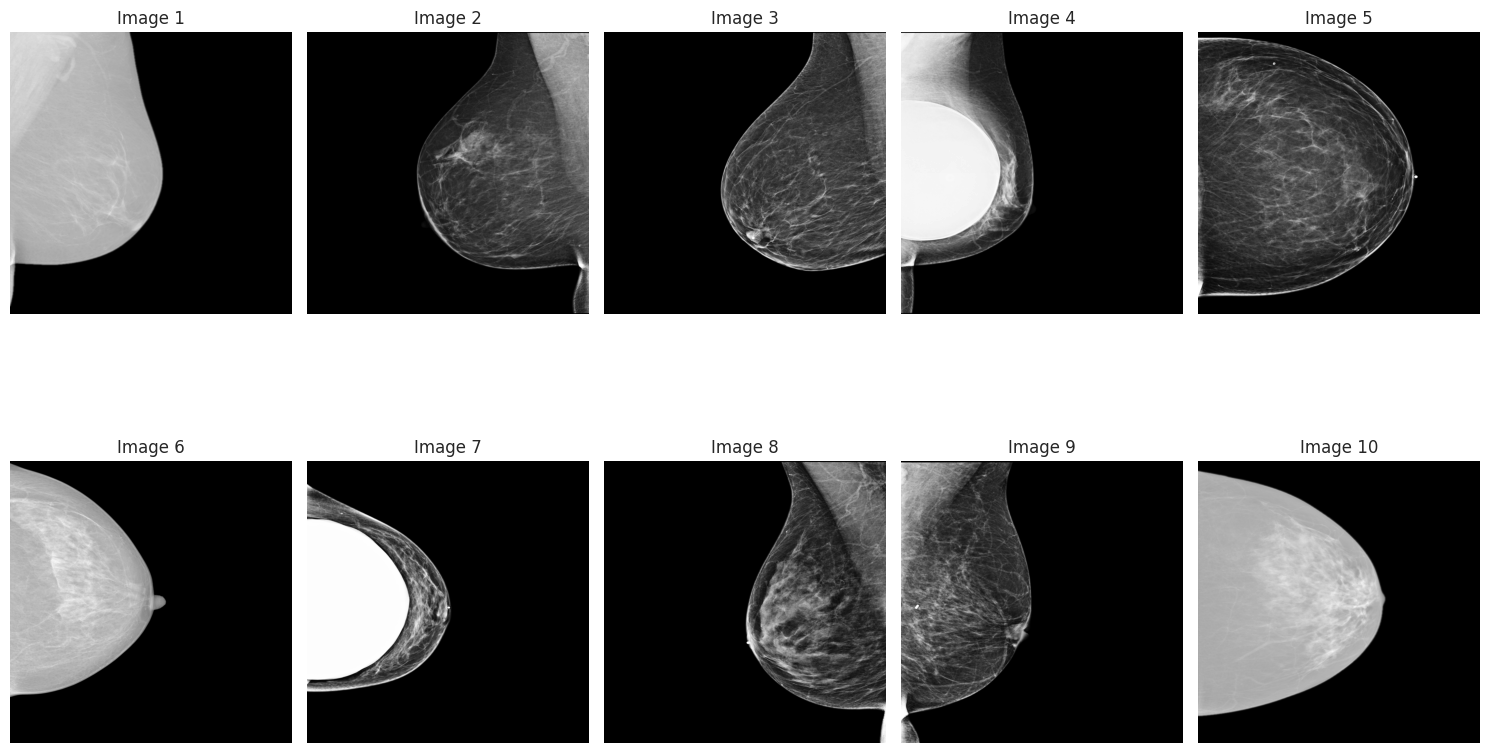

In [19]:
    # Выбираем 10 случайных изображений
    random_images_1 = random.sample(image_paths, min(10, len(image_paths)))
    # Отображаем изображения
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(random_images_1):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # 2 строки, 5 колонок
        plt.imshow(get_clean_image_new(img), cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

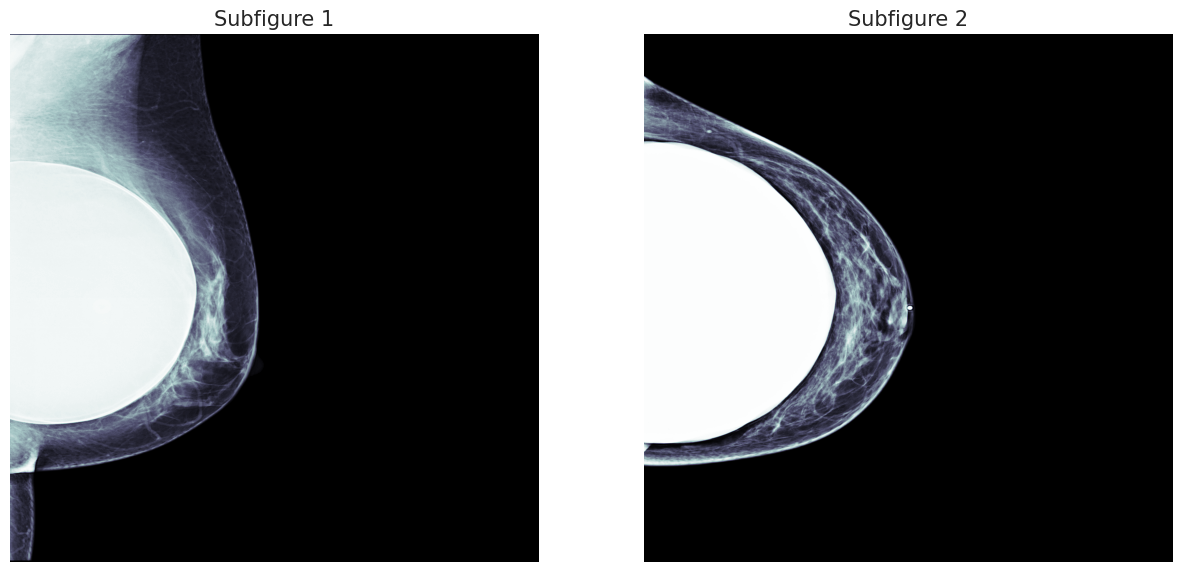

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

sns.set_style('darkgrid')
sns.set_palette('Set2')

axs = axs.flatten()

_ = axs[0].imshow(get_clean_image(Image.open(random_images_1[3])), cmap="bone")
_ = axs[0].axis("off")
_ = axs[0].set_title("Subfigure 1", fontsize=15)
_ = axs[1].imshow(get_clean_image(Image.open(random_images_1[6])), cmap="bone")
_ = axs[1].axis("off")
_ = axs[1].set_title("Subfigure 2", fontsize=15)

С чисто качественной точки зрения, похоже, что наличие имплантатов может поставить под сомнение эффективность. Имплантаты рентгеноконтрастны, что означает, что они перекрывают рентгеновские лучи, используемые для получения маммограммы. В свою очередь, это значительно затрудняет просмотр фактической ткани молочной железы. Конечно, на приведенных выше снимках это может представлять серьезную проблему. Давайте посмотрим, распространена ли одна и та же проблема на всех доступных снимках.

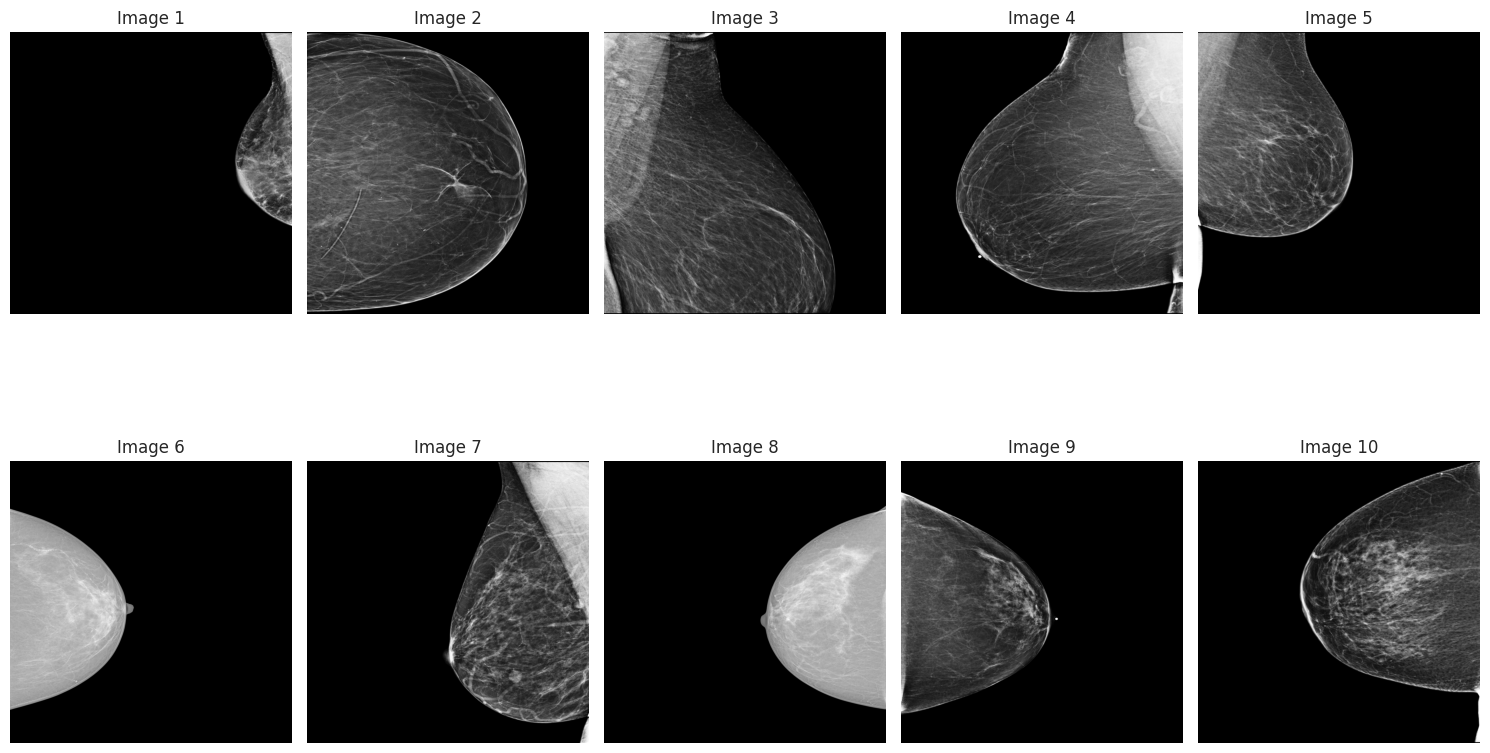

In [24]:
    # Выбираем 10 случайных изображений
    random_images_impl = random.sample(image_paths, min(10, len(image_paths)))
    # Отображаем изображения
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(random_images_impl):
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # 2 строки, 5 колонок
        plt.imshow(get_clean_image_new(img), cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [38]:
train[(train["implant"] == 1)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 793 to 54578
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  1477 non-null   int64  
 1   patient_id               1477 non-null   int64  
 2   image_id                 1477 non-null   int64  
 3   laterality               1477 non-null   object 
 4   view                     1477 non-null   object 
 5   age                      1477 non-null   float64
 6   cancer                   1477 non-null   int64  
 7   biopsy                   1477 non-null   int64  
 8   invasive                 1477 non-null   int64  
 9   BIRADS                   1244 non-null   float64
 10  implant                  1477 non-null   int64  
 11  density                  1460 non-null   object 
 12  machine_id               1477 non-null   int64  
 13  difficult_negative_case  1477 non-null   bool   
dtypes: bool(1), float64(2), in

Имплантат закрывает вид на ткани молочной железы, в то время как на некоторых изображениях того же пациента такие окклюзии отсутствуют. Это может быть связано с серией снимков, выполняемых до и после операции по имплантации. Однако более вероятно, что специалист, выполняющий маммографию, выполняет смещение имплантата, при котором имплантат мягко прижимается к стенке грудной клетки, а ткань молочной железы перемещается вперед. Необходимость смещения имплантата, весьма вероятно, является причиной увеличения количества сделанных изображений

Основные замечания по поводу изображений с имплантатами.
- Грудные имплантаты рентгеноконтрастны, и из-за них трудно разглядеть подлежащие ткани молочной железы.
- Такие методы, как смещение имплантата, позволяют делать снимки тканей молочной железы путем перемещения имплантата к грудной стенке. При наличии импланта на изображении делается больше снимков, вероятно, из-за необходимости выполнения техники смещения для получения более четких изображений.
- Изображения пациента могут содержать смесь изображений с четко видимыми имплантатами и без них.
- Мы должны знать, что имплантаты могут вносить шум в наш классификатор изображений.

Возможно необходимо рассмотреть возможность удаления изображений с имплантатами из обучающего набора или разработки программной метки для предварительной классификации наличия имплантатов, чтобы изображения со значительными окклюзиями из-за имплантатов не влияли излишне на производительность классификатора.

### 4 - Горизонтальные инверсии изображений
Мы уже видели примеры инверсии изображений. Чтобы объяснить немного подробнее, каждая запись имеет горизонтальность, которая описывает, какую сторону представляет изображение. Мы ожидали бы, что L или левая боковина будет присутствовать на одной стороне изображения, а R или правая боковина - на другой стороне. Давайте взглянем на несколько изображений наугад и проверим, справедливо ли это для предоставленных нам тестовых изображений.

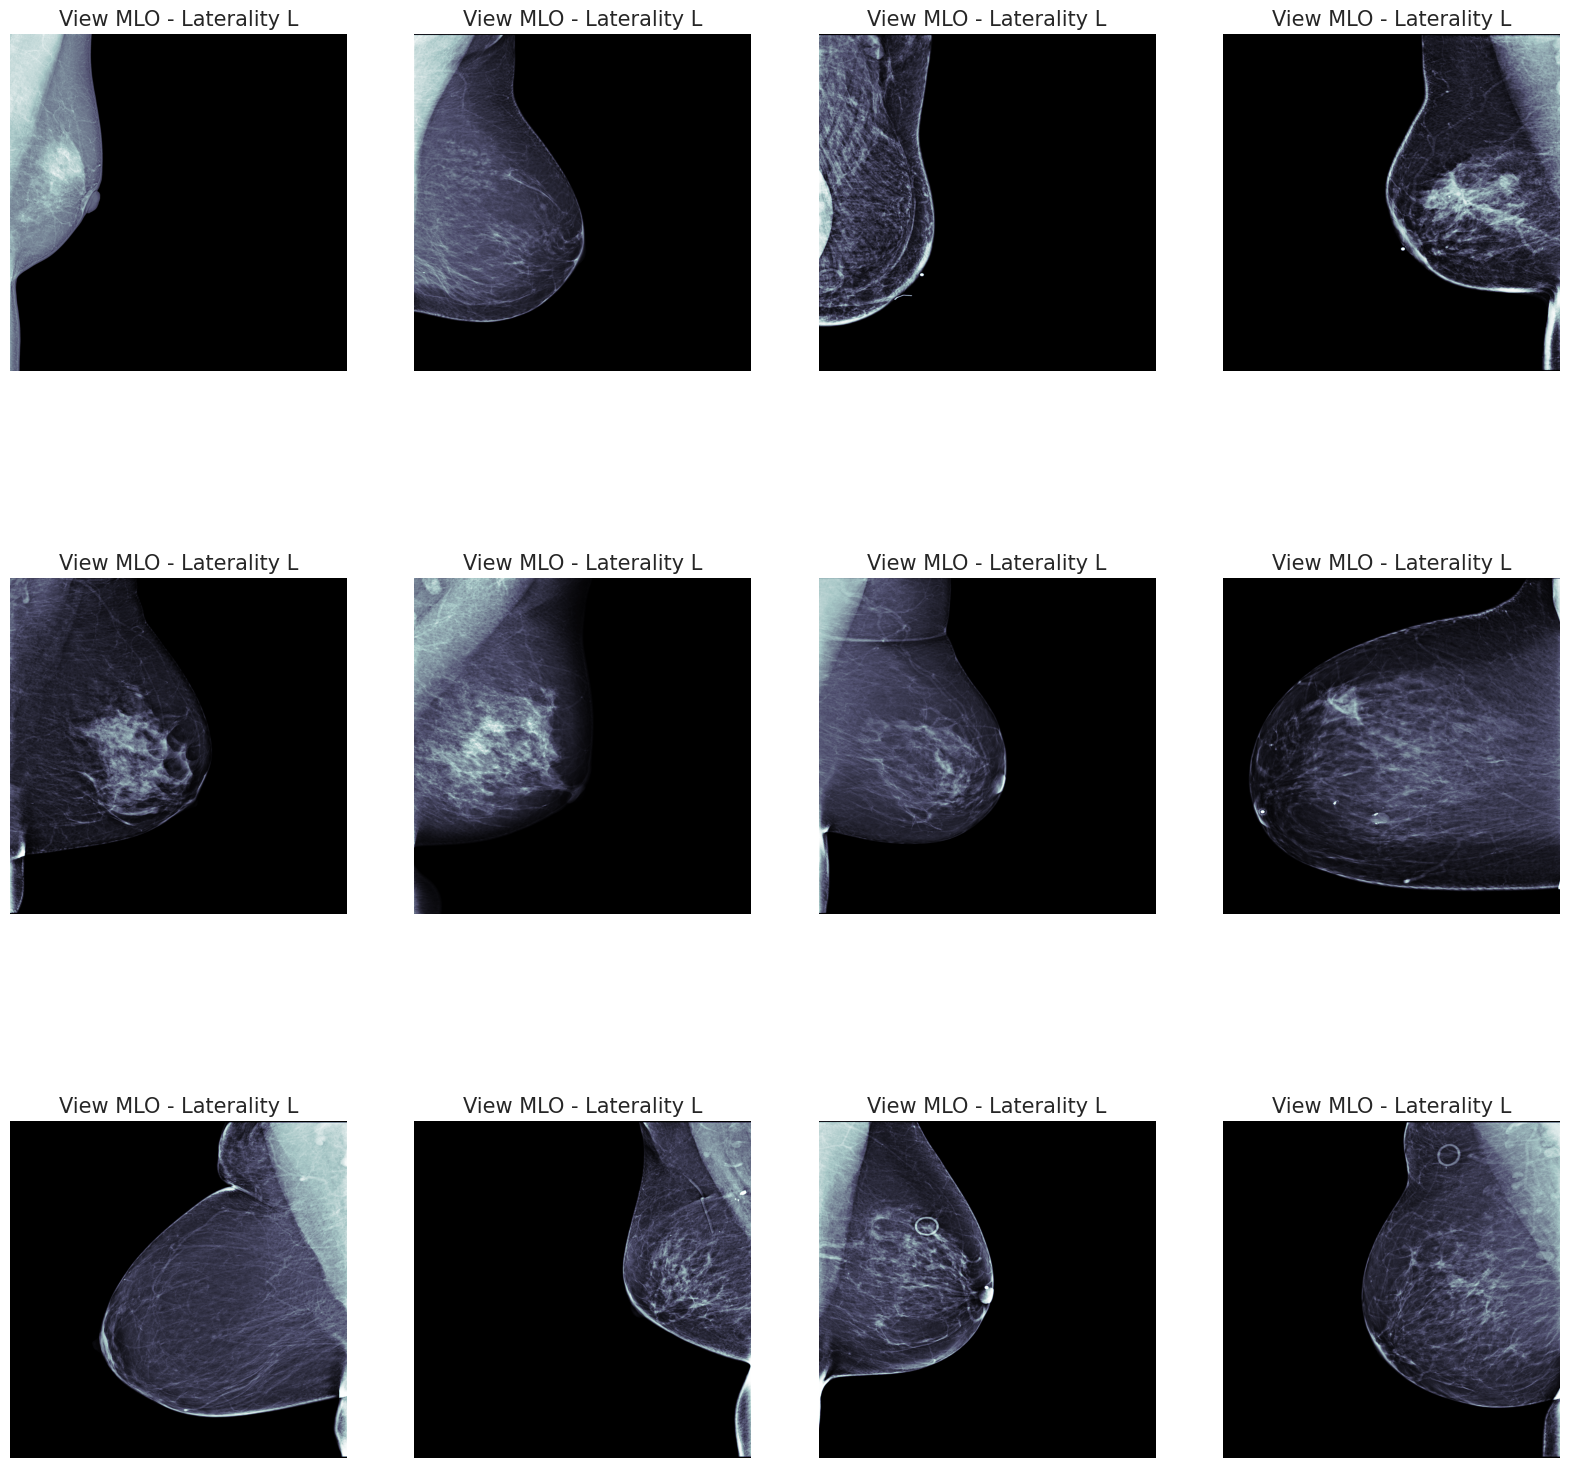

In [25]:
import os
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv("../input/rsna-breast-cancer-detection/train.csv")
test = pd.read_csv("../input/rsna-breast-cancer-detection/test.csv")

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))

sns.set_style('darkgrid')
sns.set_palette('Set2')

axs = axs.flatten()

count = 0
skip_count = 100
skip = False

for index, row in train[(train["laterality"] == "L") & (train["view"] == "MLO")].iterrows():
    if skip == 0:
        skip = 100
        _ = axs[count].imshow(get_clean_image(Image.open('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/'+str(row["patient_id"])+'/'+str(row["image_id"])+'.png')), cmap="bone")
        _ = axs[count].axis("off")
        _ = axs[count].set_title("View {} - Laterality {}".format(row["view"], row["laterality"]), fontsize=15)
        count += 1
        if count > 11:
            break
    else:
        skip -= 1

Мы можем видеть, что, хотя мы смотрим на L с точки зрения MLO, у нас есть изображение, на котором грудная стенка видна как с правой, так и с левой стороны изображения. Хотя мы могли бы нормализовать каждое L и R к их соответствующим сторонам, было бы целесообразнее ориентировать все изображения одинаково. Причина этого шага заключается в том, что мы, вероятно, хотим начать создавать стандартный/нормализованный вид каждого изображения. Чтобы сделать это, мы сориентируем наши изображения таким образом, чтобы грудная клетка находилась с левой стороны изображения.

Простой способ убедиться, что каждое изображение ориентировано так, как мы хотим, - это просто найти центральную линию в нашем существующем изображении и использовать Python's Numpy, чтобы разрезать массив изображений пополам. Затем мы замаскируем каждый пиксель таким образом, чтобы он был равен нулю или единице (включен или выключен), а затем суммируем массивы. Если в правом массиве больше пикселей по сравнению с левым, то мы используем OpenCV для переворачивания изображения. Вот как выглядят изображения выше, когда мы применяем этот метод.

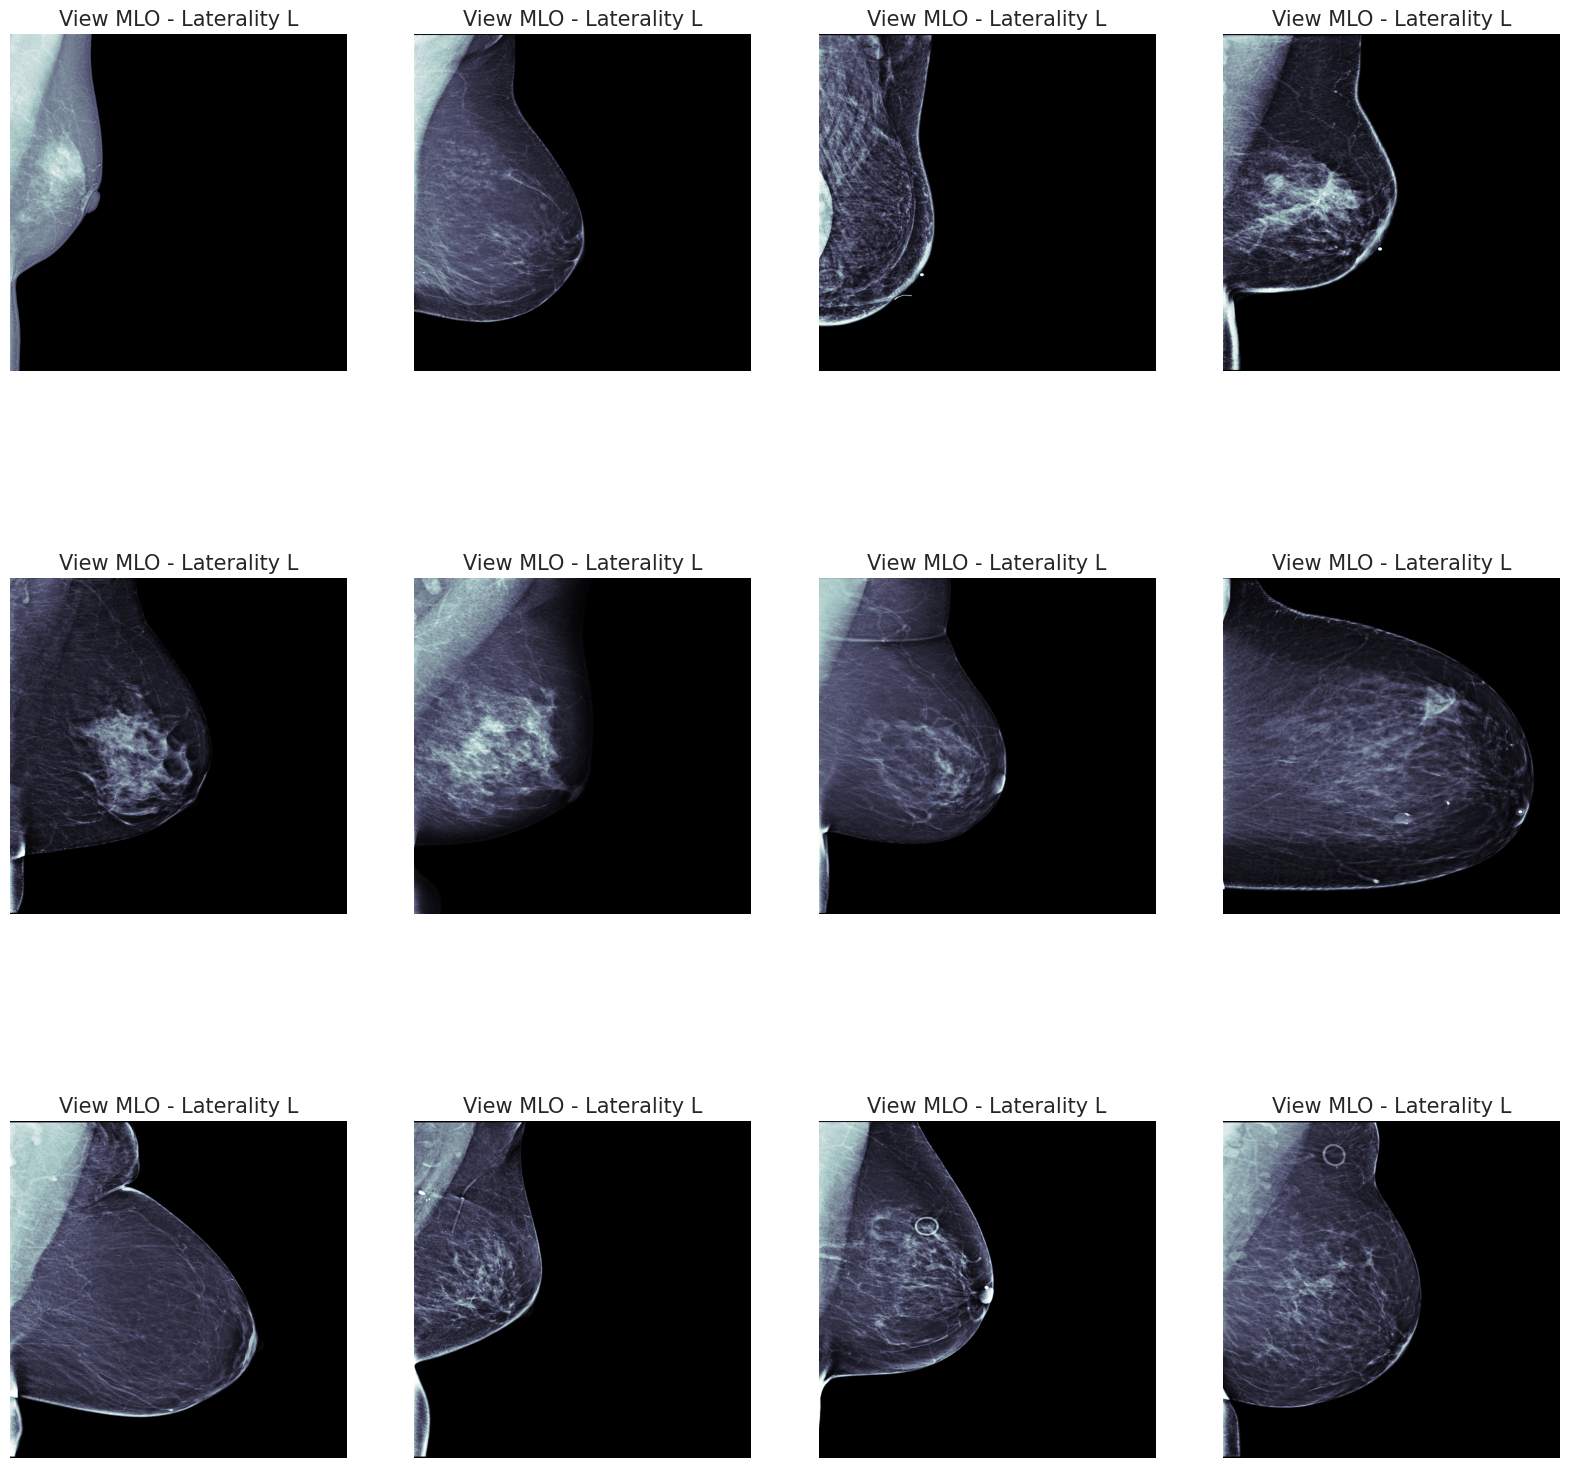

In [41]:
def slice_image(img):
    _, width = img.shape
    new_width = int(width / 2)
    left_img = img[:, 0:new_width]
    right_img = img[:, new_width:]
    return left_img, right_img

def mask_pixels(img):
    img[img > 1] = 1
    return img

def count_pixels(img):
    return np.sum(img)

def normalize_horiz_orientation(img):
    left_img, right_img = slice_image(mask_pixels(img.copy()))
    if count_pixels(right_img) > count_pixels(left_img):
        return cv2.flip(img, 1)
    return img

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))

sns.set_style('darkgrid')
sns.set_palette('Set2')

axs = axs.flatten()

count = 0
skip_count = 100
skip = False

for index, row in train[(train["laterality"] == "L") & (train["view"] == "MLO")].iterrows():
    if skip == 0:
        skip = 100
        _ = axs[count].imshow(normalize_horiz_orientation(get_clean_image(Image.open('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/'+str(row["patient_id"])+'/'+str(row["image_id"])+'.png'))), cmap="bone")
        _ = axs[count].axis("off")
        _ = axs[count].set_title("View {} - Laterality {}".format(row["view"], row["laterality"]), fontsize=15)
        count += 1
        if count > 11:
            break
    else:
        skip -= 1

Основные замечания по поводу горизонтальных инверсий изображения
- Латеральность изображения не стандартизирована для L и R в зависимости от того, с какой стороны изображения видна грудная стенка.
- Вероятно, нам следует привести все наши изображения к некоторой стандартной ориентации, чтобы наши алгоритмы машинного обучения имели ориентиры примерно в одних и тех же местах.

In [ ]:
'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/36387/26934018.png'